# 05. Training Embedding Vector from Scratch
In this module, rather than using pre-trained embedding vector, we allow an embedding vector changed as same as other parameters in model. In other words, An embedding vector can be trained along with the rest of the parameters.

## Initialized Data Set
As usual, import our dataset

In [169]:
# import data set
import pandas as pd
df = pd.read_csv("data/cleaned-train-tweets.csv", sep="|")

# create PyTorch data set
import torch
from torch.utils.data import Dataset
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

class DisasterTweetsDataset(Dataset):
    def __init__(self, df, max_vocab_size, vocabulary = None):
        
        # load dataframe
        self.x = df["clean_text"]
        self.y = df["target"]
        

        # create vocabulary
        if not vocabulary:
            self.vocab = build_vocab_from_iterator(
                [" ".join([str(text) for text in df["clean_text"]]).split()],
                specials=['<unk>'],
                max_tokens = max_vocab_size)
            self.vocab.set_default_index(self.vocab['<unk>'])
        else:
            self.vocab = vocabulary

    @property
    def vocab_size(self):
        # add one more for out of vocab words
        return len(self.vocab) + 1
    
    def get_vocab(self):
        return self.vocab

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        x = self.x[i]
        y = self.y[i]
        return (y, x)

# initiate dataset and vocabulary
dataset = DisasterTweetsDataset(df, 10000)
vocab = dataset.get_vocab()

## Collation Function
Letting the embedding matrix be changed is a complicated task. We has to create a new collation function that map each token to its corresponding index in the vocabulary. Since each tweet has different length. We need to pad each tweet that make the number of tokens of each tweet match the highest length of tweet in the batch.

In [170]:
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
def collate_fn(batch):
    """
    collate the dataset into bag of words representation
    
    input:
        - batch (list(str, int)): a list of dataset in forms of label, text
    return:
        - (tensor): a tensor of labels
        - (tensor): a tensor of bag of words
    """

    max_tweet_indexes_size = -float("inf")
    labels, tweet_indexes = [], []
    for label, tweet in batch:
        labels.append(int(label))
        tweets = str(tweet).split()
        max_tweet_indexes_size = max(max_tweet_indexes_size, len(tweets))
        tweet_indexes.append(vocab(tweets))
    # pad tweet_indexes
    temp = [tweet_index + [0] * max_tweet_indexes_size for tweet_index in tweet_indexes]
    tweet_indexes = [x[0: max_tweet_indexes_size] for x in temp]

    return (
        torch.tensor(labels, dtype=torch.int64), 
        torch.tensor(tweet_indexes)
    )

## Training Pipeline
We previously knew that the best model so far is bidirectional LSTM. We continue the experiment with BiLSTM model, but rather keep the embedding matrix freezing, we train the embedding matrix along with other parameters

In [176]:
# Initiate a dataloader and split the data into train and validation dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader

def new_dataloader(dataset, collate_fn, batch_size=64, split_train_ratio=0.7):
    num_train = int(len(dataset) * split_train_ratio)
    num_valid = len(dataset) - num_train
    train_data, valid_data = random_split(
        dataset,
        [num_train, num_valid]
    )
    train_dataloader = DataLoader(
        train_data, 
        batch_size=batch_size, 
        shuffle=True,
        collate_fn=collate_fn
    )
    valid_dataloader = DataLoader(
        valid_data, 
        batch_size=batch_size,
        shuffle=False, 
        collate_fn=collate_fn)
    return (train_dataloader, valid_dataloader)

# helper function: repackage hidden
def repackage_hidden(h):
    """
    Wraps hidden states in new Tensors, to detach them from their history.
    """
    if h is None:
        return None
    elif isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)


# function for training an epoch
def train_an_epoch(dataloader, model, hidden, loss_function, optimizer, 
                   clip_grad, max_norm):
    model.train() # Sets the module in training mode.
    log_interval = 500

    for idx, (label, text) in enumerate(dataloader):
        hidden = repackage_hidden(hidden)
        model.zero_grad()
        output, hidden = model(text, hidden)
        loss = loss_function(output.view(-1, output.size(-1)), label.view(-1))
        loss.backward()
        if clip_grad:
            torch.nn.utils.clip_grad_norm_(
                parameters=model.parameters(), 
                max_norm=max_norm # default GRAD_CLIP = 1
            )
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

# function for calculate the accuracy for a given dataloader
def get_accuracy(dataloader, model):
    model.eval()
    with torch.no_grad():
        hidden = None
        total_acc, total_count = 0, 0
        for _, (label, text) in enumerate(dataloader):
            log_probs, hidden = model(text, hidden)
            predicted_label = torch.argmax(log_probs, dim=1)
            total_acc += (predicted_label == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

# putting all together, create function for training
import matplotlib.pyplot as plt
import time

def training(dataset, collate_fn, batch_size, split_train_ratio, 
             model, epochs, loss_function, optimizer, clip_grad, max_norm):
    
    # create dataloader from dataset
    train_dataloader, valid_dataloader = new_dataloader(
        dataset, collate_fn, batch_size, split_train_ratio)

    # training
    accuracies = []
    max_val_acc = -float("inf")
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        hidden = None
        train_an_epoch(train_dataloader, model, hidden, loss_function, optimizer,
                       clip_grad, max_norm)
        accuracy = get_accuracy(valid_dataloader, model)
        accuracies.append(accuracy)
        time_taken = time.time() - epoch_start_time
        print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
        # persist the best model
        if accuracy > max_val_acc:
            print("the best model has validation accuracy at {}".format(accuracy))
            best_model = type(model)( 
                model.num_embeddings,
                model.embedding_dim,
                model.hidden_size, 
                model.out_features,
                model.num_layers, 
                model.dropout
            )
            best_model.load_state_dict(model.state_dict())
            max_val_acc = accuracy
    
    plt.plot(range(1, epochs + 1), accuracies)

In [179]:
# Initiate an BiLSTM classifier
from torch import nn
import torch.nn.functional as F

class BiLSTMClassifier(nn.Module):
    """
    Initialize RNN classifier

    Args:
        - input_size (int): size of embedding vector (number of features) 
            for each word (default: 300)
        - hidden_size (int): the number of features in the hidden state (def: 300)
    """
    def __init__(self, num_embeddings, embedding_dim, hidden_size, out_features,
                 num_layers, dropout=0.5):
        super(BiLSTMClassifier, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.out_features = out_features
        self.num_layers = num_layers
        self.dropout = dropout

        self.drop = nn.Dropout(dropout)
        self.encoder = self.encoder = nn.Embedding(
            num_embeddings=num_embeddings, 
            embedding_dim=embedding_dim
        )
        self.rnn = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            bidirectional=True
        )

        self.decoder = nn.Linear(in_features=hidden_size * 2, 
                                 out_features=out_features)
        
    
    def forward(self, input, hidden0):
        embedding = self.drop(self.encoder(input))
        x = torch.mean(embedding, 1)
        output, hidden = self.rnn(x, hidden0)
        output = self.drop(output)
        decoded_output = self.decoder(output)
        decoded_output = F.log_softmax(self.decoder(output), dim=1)
        return decoded_output, hidden

After epoch 1 the validation accuracy is 0.733.
the best model has validation accuracy at 0.7333092746300974
After epoch 2 the validation accuracy is 0.774.
the best model has validation accuracy at 0.7740887766149405
After epoch 3 the validation accuracy is 0.810.
the best model has validation accuracy at 0.810357271743053
After epoch 4 the validation accuracy is 0.823.
the best model has validation accuracy at 0.8231685312161674
After epoch 5 the validation accuracy is 0.840.
the best model has validation accuracy at 0.8395885961746662
After epoch 6 the validation accuracy is 0.844.
the best model has validation accuracy at 0.843558282208589
After epoch 7 the validation accuracy is 0.844.
After epoch 8 the validation accuracy is 0.854.
the best model has validation accuracy at 0.854384698664742
After epoch 9 the validation accuracy is 0.856.
the best model has validation accuracy at 0.8563695416817033
After epoch 10 the validation accuracy is 0.858.
the best model has validation accu

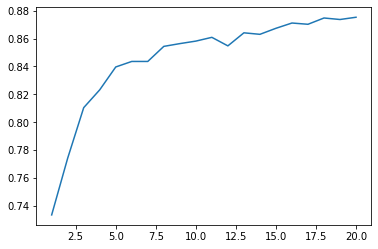

In [181]:
# BiLSTM Model
embedding_model = BiLSTMClassifier(
    num_embeddings=10000,
    embedding_dim=300,
    hidden_size=300,
    out_features=2,
    num_layers=2,
    dropout=0.5
)

# initialize parameters
DATASET = dataset
COLLATE_FN = collate_fn
BATCH_SIZE = 64
SPLIT_TRAIN_RATIO = 0.7
MODEL = embedding_model
EPOCHS = 20
LOSS_FUNCTION = torch.nn.NLLLoss()
OPTIMIZER = torch.optim.Adam(MODEL.parameters())
CLIP_GRAD = True
MAX_NORM = 1

training(DATASET, COLLATE_FN, BATCH_SIZE, SPLIT_TRAIN_RATIO, MODEL, EPOCHS, 
         LOSS_FUNCTION, OPTIMIZER, CLIP_GRAD, MAX_NORM)